### CNN for CIFAR10

CNN model that can be used for classification tasks. 

In this demo, we will train a 3-layer CNN on the CIFAR10 dataset. We will show 2 implementations of the CNN model. First is using PyTorch's  built-in `nn.Conv2d` API. Second, is we will use tensor level convolution. 

Let us first import the required modules.

In [4]:
import torch
import torchvision
import math
import time

import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from matplotlib import image


#### CNN using PyTorch `nn.Conv2D`

In this example, we use `nn.Conv2D` to create a 3-layer CNN model. Note the following:
1. The first layer number of input features is equal to the number of input RGB channels (3).
2. The output of the first layer is equal to the number of input features of the second layer.
3. The same matching for the second and third (last) layer.
4. We use `nn.MaxPool2d` to reduce the output feature map size.
5. At the same, we increase the number of feature maps after every layer.
6. We use `nn.ReLU` to activate the output of the layer.
7. For the last linear layer `nn.Linear`, the number of input features has to be supplied manually. Below in comment is a simple script that can be used to calculate the number of input features.

Ideas for experimentation:
1. Try other kernel sizes
2. Try deeper models
3. Try different activation functions
4. Try applying skip connections


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, n_features=3, kernel_size=3, n_filters=32, num_classes=10, conv2d=nn.Conv2d):
        super().__init__()
        self.conv1 = conv2d(n_features, n_filters, kernel_size=kernel_size)
        self.conv2 = conv2d(n_filters, n_filters*2, kernel_size=kernel_size)
        self.conv3 = conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size)
        
        self.fc1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv2(y))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv3(y))
        y = y.contiguous().view(y.size(0), -1)

        y = self.fc1(y)
        return y

Files already downloaded and verified
Files already downloaded and verified
Number of model parameters: 0.11 million
Running on: cuda
Epoch: 1, Train Loss: 1.6080, Train Acc: 40.74%, Test Loss: 1.3137, Test Acc: 52.65%, LR: 0.000976, Time: 11.75s
Epoch: 2, Train Loss: 1.3008, Train Acc: 53.59%, Test Loss: 1.1108, Test Acc: 60.29%, LR: 0.000905, Time: 11.66s
Epoch: 3, Train Loss: 1.1520, Train Acc: 59.12%, Test Loss: 1.0218, Test Acc: 63.52%, LR: 0.000794, Time: 11.60s
Epoch: 4, Train Loss: 1.0589, Train Acc: 62.87%, Test Loss: 0.9208, Test Acc: 67.64%, LR: 0.000655, Time: 11.68s
Epoch: 5, Train Loss: 0.9871, Train Acc: 65.51%, Test Loss: 0.8809, Test Acc: 69.38%, LR: 0.000500, Time: 11.67s
Epoch: 6, Train Loss: 0.9341, Train Acc: 67.36%, Test Loss: 0.8406, Test Acc: 70.75%, LR: 0.000345, Time: 11.62s
Epoch: 7, Train Loss: 0.8897, Train Acc: 69.04%, Test Loss: 0.8204, Test Acc: 71.79%, LR: 0.000206, Time: 11.68s
Epoch: 8, Train Loss: 0.8607, Train Acc: 69.97%, Test Loss: 0.7814, Test Ac

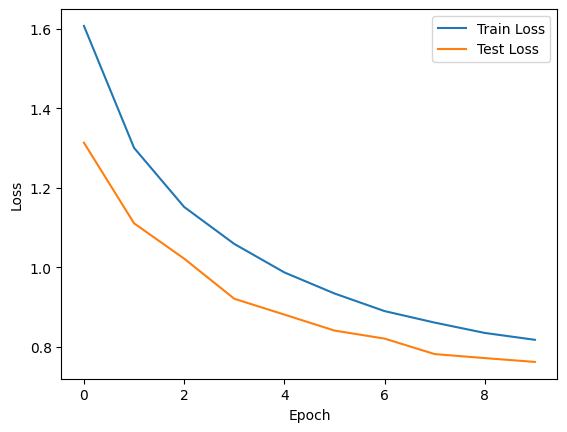

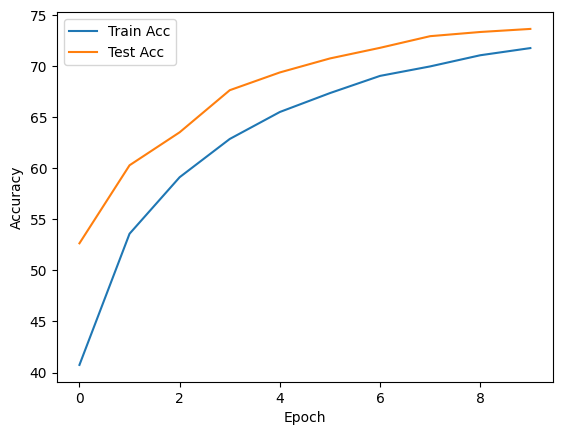

In [7]:

# define the training function
def train(model, train_loader, optimizer, criterion,  device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

       
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/(batch_idx+1), 100.*correct/total

# define the test function
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total

# define the main function
def main():
    # set the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # set the hyperparameters
    lr = 0.001
    momentum = 0.9
    weight_decay = 5e-4
    epochs = 10
    batch_size = 64

    # load the CIFAR10 dataset
    transform_train = torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='~/data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='~/data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # define the model, optimizer and loss function
    model = SimpleCNN().to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()


    # Define the learning rate scheduler
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0, last_epoch=-1)

    print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} million")
    print(f"Running on: {device}")
    # train the model
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, optimizer, criterion,  device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        end_time = time.time()
        lr_scheduler.step()

        print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%, LR: {:.6f}, Time: {:.2f}s'.format(epoch+1, train_loss, train_acc, test_loss, test_acc, optimizer.param_groups[0]['lr'], end_time-start_time))

    # plot the train and test losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the train and test accuracies
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
from einops import rearrange

class TensorConv2d(nn.Module):
    def __init__(self, n_features, n_filters, kernel_size):
        super().__init__()
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.kernel = nn.Parameter(torch.zeros((n_features * kernel_size * kernel_size, n_filters)))
        self.bias = nn.Parameter(torch.zeros(n_filters))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.bias, 0)
        nn.init.kaiming_uniform_(self.kernel, a=math.sqrt(5))
        
    def forward(self, x):
        k = self.kernel_size

        # make sure that kernel and bias are in the same device as x
        if self.kernel.device != x.device:
            self.kernel.to(x.device)
            self.bias.to(x.device)

        # batch, height, width
        b = x.shape[0]
        h = x.shape[2]
        w = x.shape[3]

        # making sure the feature map to be convolved is of the right size
        # and we dont go past beyond the the feature map boundary
        wk = k * (w // k) 
        hk = k * (h // k)
        wf = w % k 
        hf = h % k

        # Tensor Level Convolution
        # Basic idea: (Repeat kernel_size times per row and per col) 
        # 1) convert an image into patches
        # 2) perform convolution on each patch which is equivalent to 
        #  - dot product of each patch with the kernel plus bias term
        # 4) move 1 feature point along the horizontal axis (to be done kernel_size times)
        # 5) go to 1)
        # 6) move 1 feature point along the vertical axis (to be done kernel_size times)
        # 7) go to 1)

        # Tensor z contains the output of the convolution
        # make sure tensor z is the correct device as x
        z = torch.empty((b, self.n_filters, h-k+1, w-k+1)).to(x.device)

        for i in range(k):
            # row offset 
            # we need to perform offset k times
            hoff = i if hf >= i else (-k + i)
            for j in range(k):
                # column offset 
                # we need to perform offset k times
                woff = j if wf >= j else (-k + j)
                
                # shift i row and j col
                y = x[:, :, i: hk + hoff:, j: wk + woff:]
        
                # convert to patches (p1 p2 c)
                y = rearrange(y, "b c (h p1) (w p2) -> b h w (p1 p2 c)", p1=k, p2=k)
                # dot product plus bias term
                y = y @ self.kernel + self.bias

                # sparse feature map: channel first
                y = rearrange(y, 'b h w c -> b c h w')

                # assign the feature map to the correct position in the output tensor
                z[:,:,i::k,j::k] = y
        
        return z